**This notebook visualizes the relationship between the initial 2D reprojection errors and the final pose errors (Figure 7).**

In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

from pixloc.settings import DATA_PATH, LOC_PATH, EVAL_PATH
from pixloc.run_Aachen import default_paths
from pixloc.localization import Model3D
from pixloc.pixlib.geometry import Camera, Pose
from pixloc.utils.parser import parse_image_lists
from pixloc.utils.eval import cumulative_recall

In [1]:
paths = default_paths.add_prefixes(DATA_PATH/'Aachen', LOC_PATH/'Aachen')
sfm = Model3D(paths.reference_sfm)

hloc_path = paths.dumps / 'Aachen_hloc_superpoint+superglue_netvlad50.txt'
hloc_poses = dict(parse_image_lists(hloc_path, with_poses=True))
with open(str(hloc_path)+'_logs.pkl', 'rb') as file:
    loc_logs = pickle.load(file)
    
results_path = EVAL_PATH / 'pixloc_Aachen.txt'
pred_poses = dict(parse_image_lists(results_path, with_poses=True))
with open(str(results_path)+'_logs.pkl', 'rb') as f:
    pred_logs = pickle.load(f)
    
qnames = list(loc_logs['loc'].keys())
qdata = parse_image_lists(paths.query_list, with_intrinsics=True)
qdata = {Path(q).name: cam for q, cam in qdata}
assert set(Path(q).name for q in qnames) == set(qdata)

[09/15/2021 12:24:50 pixloc.localization.model3d INFO] Reading COLMAP model /home/psarlin/work/geometry/FeatureMetric-Pose-Estimation/outputs/hloc/Aachen/sfm_superpoint+superglue.
[09/15/2021 12:25:02 pixloc.utils.parser INFO] Imported 922 images from Aachen_hloc_superpoint+superglue_netvlad50.txt
[09/15/2021 12:25:08 pixloc.utils.parser INFO] Imported 922 images from refinement_Aachen_retrieval-hloc_unet-md-interp75-unc-damp_MS4.1-n3-it100.txt
[09/15/2021 12:25:08 pixloc.utils.parser INFO] Imported 98 images from night_time_queries_with_intrinsics.txt
[09/15/2021 12:25:08 pixloc.utils.parser INFO] Imported 824 images from day_time_queries_with_intrinsics.txt


# Get the inlier ranking

In [2]:
init_poses = {}
p3d_ids = {}
conf = pred_logs['configuration']['refinement']
for qname in tqdm(qnames):
    loc = loc_logs['loc'][qname]
    dbids = loc['db']
    inliers = loc['PnP_ret']['inliers']
    
    ninl_dbs = sfm.get_db_inliers(loc, dbids, inliers)
    dbids = sfm.rerank_and_filter_db_images(dbids, ninl_dbs, conf['num_dbs'], 10)
    key = Path(qname).name
    if len(dbids) > 0:
        init_poses[key] = sfm.dbs[dbids[0]]
        p3did_to_dbids = sfm.get_p3did_to_dbids(dbids, loc, inliers)
        p3d_ids[key] = list(p3did_to_dbids.keys())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 922/922 [00:09<00:00, 93.06it/s]


# Compute initial and final 2D reprojection errors

In [3]:
def project(p3d, im, cam):
    T_w2cam = Pose.from_colmap(im)
    p2d, mask = cam.world2image(T_w2cam * p3d)
    size = pred_logs['configuration']['network']['resize']
    max_ = max(cam.size.numpy())
    if max_ > size:
        p2d = (p2d + 0.5) / max_ * size - 0.5
    return p2d.numpy(), mask.numpy()

def pose_error(names, poses_gt, poses):
    T_w2gt = Pose.stack([Pose.from_colmap(poses_gt[q]) for q in names])
    T_w2cam = Pose.stack([Pose.from_colmap(poses[q]) for q in names])
    dt = np.linalg.norm((T_w2gt @ T_w2cam.inv()).t, axis=-1)
    return dt

err2d_init = []
err2d_pred = []
names = []
for q in tqdm(init_poses):
    p3d = np.stack([sfm.points3D[i].xyz for i in p3d_ids[q]])
    cam = Camera.from_colmap(qdata[q])
    p2d_gt, mask = project(p3d, hloc_poses[q], cam)
    if np.count_nonzero(mask) == 0:
        continue
    
    p2d_pred, _ = project(p3d, pred_poses[q], cam)
    e2d_pred = np.linalg.norm(p2d_gt - p2d_pred, axis=1)[mask].mean()
    p2d_init, _ = project(p3d, init_poses[q], cam)
    e2d_init = np.linalg.norm(p2d_gt - p2d_init, axis=1)[mask].mean()
    
    err2d_init.append(e2d_init)
    err2d_pred.append(e2d_pred)
    names.append(q)

err2d_init = np.array(err2d_init)
err2d_pred = np.array(err2d_pred)
err_init = pose_error(names, hloc_poses, init_poses)
err_pred = pose_error(names, hloc_poses, pred_poses)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 919/919 [00:06<00:00, 137.14it/s]


# Define bins and count

In [4]:
bins = np.logspace(np.log10(20),np.log10(1500), 13)
prob = []
for i in range(len(bins)-1):
    select = err_pred[(err2d_init>bins[i]) & ((err2d_init<=bins[i+1]))]
    p = np.mean(select <= 1)
    prob.append(p)
prob

[1.0,
 0.8461538461538461,
 0.9574468085106383,
 0.9333333333333333,
 0.8933333333333333,
 0.8176795580110497,
 0.8277777777777777,
 0.6752136752136753,
 0.410958904109589,
 0.35,
 0.0,
 0.0]

# Histogram

Recall of oracle @1m: 4.13%


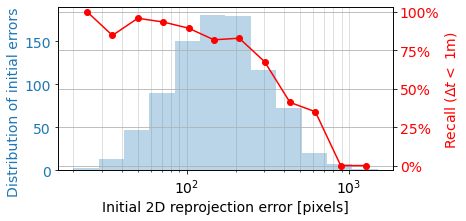

In [24]:
mpl.rc('font', size=14)
print(f'Recall of oracle @1m: {np.mean(err_init<1)*100:.3}%')

fig, ax2 = plt.subplots(figsize=(6, 3))
ax2.set_xlabel('Initial 2D reprojection error [pixels]')
plt.grid(axis='x', which='both', alpha=0.5)

color = 'tab:blue'
ax2.hist(err2d_init, bins=bins, alpha=0.3, color=color, zorder=5);
ax2.set_ylabel('Distribution of initial errors', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.yaxis.set_label_coords(-0.11,0.42)

ax1 = ax2.twinx()
color = 'red'
ax1.plot((bins[1:]+bins[:-1])/2, prob, 'o-', c=color, zorder=20)
ax1.set_ylabel('Recall ($\Delta t < $ 1m)', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_ylim([-.03, 1.03])
ax1.grid()
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))

# plt.savefig('convergence_stats_Aachen.pdf', bbox_inches='tight', pad_inches=0)

# Cumulative recall

Prediction: [70.51142546 75.40805223 81.93688792]
Initial:    [ 0.10881393  1.19695321 47.8781284 ]


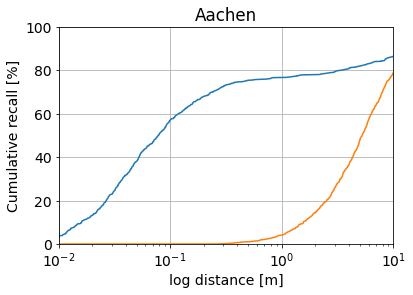

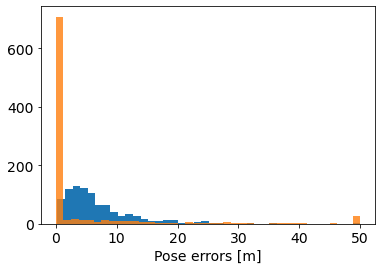

In [42]:
x, y = cumulative_recall(err_pred)
plt.plot(x, y)
recall = y[np.searchsorted(x, [0.25, 0.5, 5])]
print('Prediction:', recall)

x, y = cumulative_recall(err_init)
plt.plot(x, y)
recall = y[np.searchsorted(x, [0.25, 0.5, 5])]
print('Initial:   ', recall)

plt.xlim([0.01, 10])
plt.ylim([0, 100])
plt.grid()
plt.xscale('log')
plt.xlabel('log distance [m]')
plt.ylabel('Cumulative recall [%]');
plt.title(f'Aachen');

plt.figure()
plt.hist(np.clip(err_init, a_max=50, a_min=None), bins=40, alpha=1.);
plt.hist(np.clip(err_pred, a_max=50, a_min=None), bins=40, alpha=.8);
plt.xlabel('Pose errors [m]');